In this notebook, we attempt to attack GraphRNN. We have one (partial) run of the algorithm (on a smallish dataset): can we infer which samples are in the training set?

In [1]:
import pickle
import numpy as np
import networkx as nx
import os
import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data splitting

Create two subsets of this dataset (dataset 1 ("train") and 2 ("test")), as well as two additional disjoint subsets for each. These datasets will later be fed to GraphRNN. Only run this code once.

In [3]:
datasets_path = 'notebook_10_datasets.pkl'

In [4]:
def save_as_edgelist(list_of_graphs, path):
    L = [list(G.edges()) for G in list(list_of_graphs.data)]
    with open(path, 'wb') as ff:
        pickle.dump(L, ff)

In [5]:
if os.path.exists(datasets_path):
    with open(datasets_path, 'rb') as ff:
        subsets = pickle.load(ff)

else:
    # Sample 4 datasets of size 100 from deezer ego nets.
    import tapas.datasets
    data = tapas.datasets.TUDataset.read("deezer_ego_nets", "deezer_ego_nets")
    subsets = data.create_subsets(4, sample_size=100)
    # Save the subsets to file (make this code re-entring, in some sense).
    with open(datasets_path, 'wb') as ff:
        pickle.dump(subsets, ff)
    # Save (two of) these as edgelists.
    save_as_edgelist(subsets[0], 'deezer_subset_train.pkl')
    save_as_edgelist(subsets[2], 'deezer_subset_test.pkl')

In [6]:
TRAIN, HOLDOUT_TRAIN, TEST, HOLDOUT_TEST = subsets

## Loading data

Load the outputs that we have carefully generated.

In [7]:
def load_graphs(filename):
    with open(filename, 'rb') as ff:
        return [nx.from_edgelist(l) for l in pickle.load(ff)]

In [8]:
synthetic_graphs = load_graphs(
    '../../../graph_gen_testing/techniques/graph_rnn/graphs/deezer_subset_train_none_GraphRNN_RNN/GraphRNN_RNN_custom_multiple_deezer_subset_train_none_4_128__pred_500_1_edgelist.pkl'
)
print(len(synthetic_graphs))

1024


With this, we can divide the test set into "known" training samples and "unknown" ones.

In [9]:
training_graphs = list(TRAIN.data)
holdout_graphs_train = list(HOLDOUT_TRAIN.data)

In [10]:
np.random.shuffle(training_graphs)
np.random.shuffle(holdout_graphs_train)

In [11]:
num_train = 80

positive_train = training_graphs[:num_train]
positive_test = training_graphs[num_train:]

negative_train = holdout_graphs_train[:num_train]
negative_test = holdout_graphs_train[num_train:]

## Attack methodology

Given a graph kernel $k$, a record $G$ and a dataset of synthetic graphs $\tilde{D} = (\tilde{G}_1, \dots, \tilde{G}_m)$, we first compute the feature vector for $G$ as

$$\phi(G) = \left(k(G, \tilde{G}_i)\right)_{i \in [m]} \in \mathbb{R}^m.$$

Then, we must learn a rule to predict whether $G$ was found in the training (private) dataset $D$ used to generate $\tilde{D}$. Ideally, this rule should be relatively simple, as we don't have many training samples. Recall from previous discussions that what we really want is a _score_ that estimates membership probability: $\sigma(\tilde{d}, G) \approx \mathbb{P}[G \in D~|~\tilde{D}=\tilde{d}]$.

Another source of complexity is that the _ordering_ of the graphs in $\tilde{D}$ is arbitrary, and the rule should be symmetrical in the positions of individual synthetic graphs (i.e., permutation invariant). This does not really matter in the train-vs-test setup (maybe it can be helpful for samples tested _on one specific dataset_ to know the position of specific synthetic graphs, and interpret entries of $\phi(G)$ differently), but is crucial to allow the rule learned to generalise to other synthetic datasets!

Here are some options to consider:

1. Simple scores: $min_i \phi_i(G)$, $\frac{1}{m}\sum_i\phi_i(G)$, $perc_{\delta}(\phi(G))$ for $\delta = 0.1$. The rule learned is a simple threshold selected over training samples.
2. Function-of-histogram: first, compute a "histogram" of the values in $\phi(G)$, e.g. 10 bins between a (carefully selected) min and max, $h(\phi(G)) \in \mathbb{R}^k$ for $k \ll m$. Then, learn a function $\sigma_\theta$ of this histogram.
3. Function-of-neighbourhood: a similar idea, using as feature a (sorted) vector of the $k$ highest scores.
4. Machine Learning: learn $\theta$ such that $\sigma_\theta \circ \phi (G) \approx \mathbb{P}[G \in D]$. Note that $\tilde{D}$ is not explicitly referenced in this expression, meaning that this model is unlikely to generalise to other synthetic datasets (informally). In general, it also suffers from the permutation issue.

First, initialise the kernel.

In [12]:
import grakel
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [13]:
from grakel import WeisfeilerLehman, VertexHistogram
kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)

In [14]:
kernel.fit(_grak(synthetic_graphs))

WeisfeilerLehman(n_iter=4, normalize=True)

Compute the feature vectors.

In [15]:
X_train = kernel.transform(_grak(positive_train + negative_train))
y_train = np.array([True] * len(positive_train) + [False] * len(negative_train))

In [16]:
X_test = kernel.transform(_grak(positive_test + negative_test))
y_test = np.array([True] * len(positive_test) + [False] * len(negative_test))

### 1. Score-based attacks

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [18]:
def max_accuracy(true_label, scores):
    fpr, tpr, _ = roc_curve(true_label, scores)
    return np.max((tpr+(1-fpr))/2)

In [19]:
def evaluate_score(scoref):
    score_train = scoref(X_train)
    score_test = scoref(X_test)
    lb = min(score_train.min(), score_test.min())
    ub = max(score_train.max(), score_train.max())
    bins = np.linspace(lb, ub, 21)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(score_train[y_train], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_train[~y_train], bins=bins, facecolor='r', alpha=.5)
    plt.subplot(1, 3, 2)
    plt.hist(score_test[y_test], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_test[~y_test], bins=bins, facecolor='r', alpha=.5)
    plt.subplot(1, 3, 3)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    fp_train, tp_train, _ = roc_curve(y_train, score_train)
    fp_test, tp_test, _ = roc_curve(y_test, score_test)
    plt.plot(fp_train, tp_train, 'g', label='Train')
    plt.plot(fp_test, tp_test, 'r', label='Test')
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend()

    ev = [('AUC', roc_auc_score), ('Accuracy', max_accuracy)]
    for label, f in ev:
        print(f'Train {label.ljust(8)} ', f(y_train, score_train))
        print(f'Test {label.ljust(8)}  ', f(y_test, score_test))

Train AUC       0.5203125
Test AUC        0.55875
Train Accuracy  0.56875
Test Accuracy   0.6000000000000001


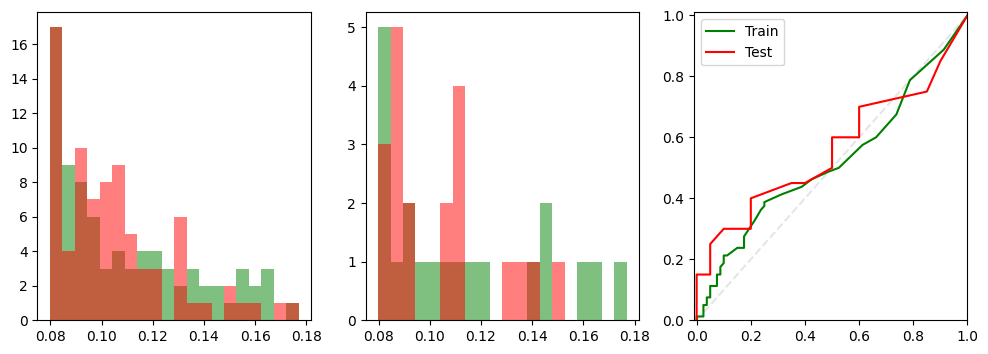

In [20]:
evaluate_score(lambda x: x.min(axis=1))

Train AUC       0.517578125
Test AUC        0.5599999999999999
Train Accuracy  0.575
Test Accuracy   0.625


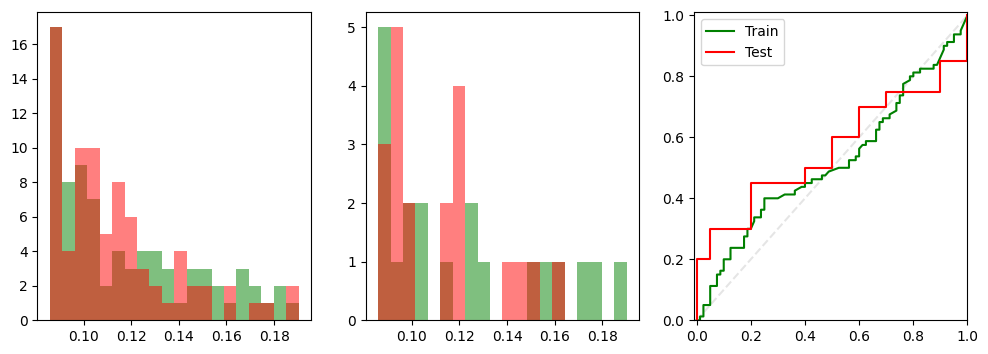

In [21]:
evaluate_score(lambda x: x.mean(axis=1))

Train AUC       0.518828125
Test AUC        0.5637500000000001
Train Accuracy  0.56875
Test Accuracy   0.625


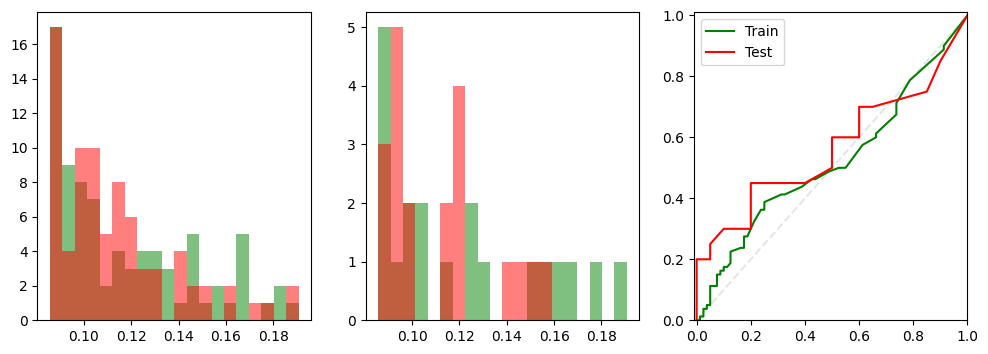

In [22]:
evaluate_score(lambda x: np.median(x, axis=1))

Train AUC       0.5279687499999999
Test AUC        0.55
Train Accuracy  0.5625
Test Accuracy   0.65


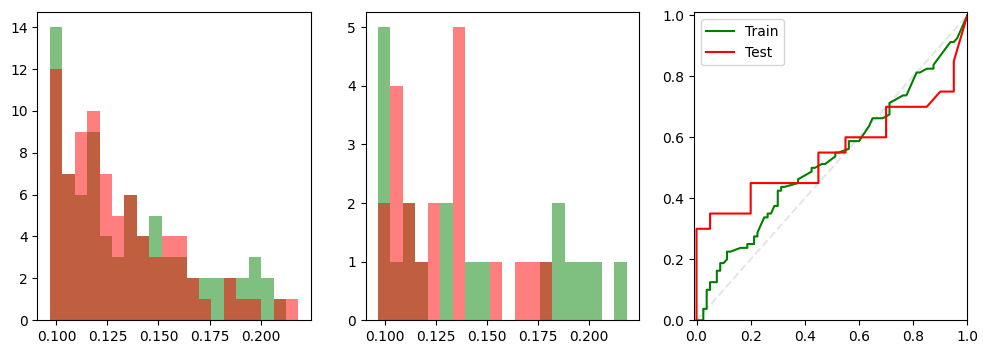

In [23]:
evaluate_score(lambda x: x.max(axis=1))

Train AUC       0.51921875
Test AUC        0.55875
Train Accuracy  0.56875
Test Accuracy   0.6000000000000001


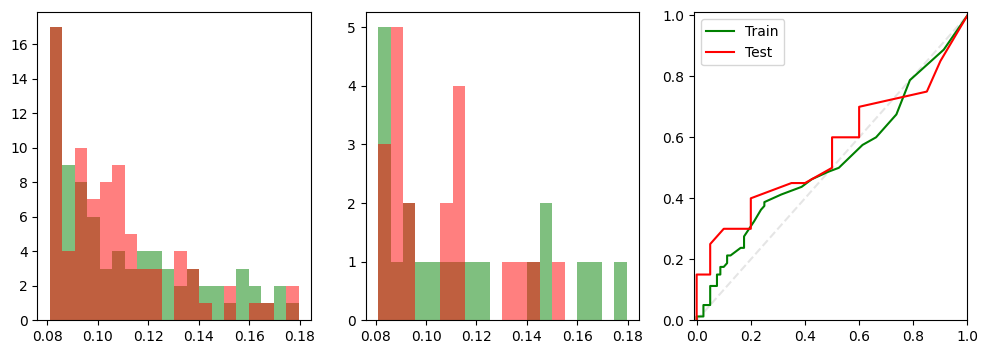

In [24]:
evaluate_score(lambda x: np.percentile(x, 0.95, axis=1))

### 2. Learning-based attacks from histograms

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [26]:
def histogram(X, k, lb=0, ub=1):  # num_entries x num_features
    bins = np.linspace(lb, ub, k+1)
    h = np.zeros((X.shape[0], k))
    for i in range(X.shape[0]):
        h[i,:] = np.histogram(X[i,:], bins=bins)[0]
        h[i,:] = h[i,:] / h[i,:].sum()
    return h

In [27]:
hist = lambda x: histogram(x, lb=0.07, ub=0.22, k=100)

In [28]:
h_train = hist(X_train)
h_test = hist(X_test)

Train AUC       0.6567968750000001
Test AUC        0.5475
Train Accuracy  0.6312500000000001
Test Accuracy   0.625


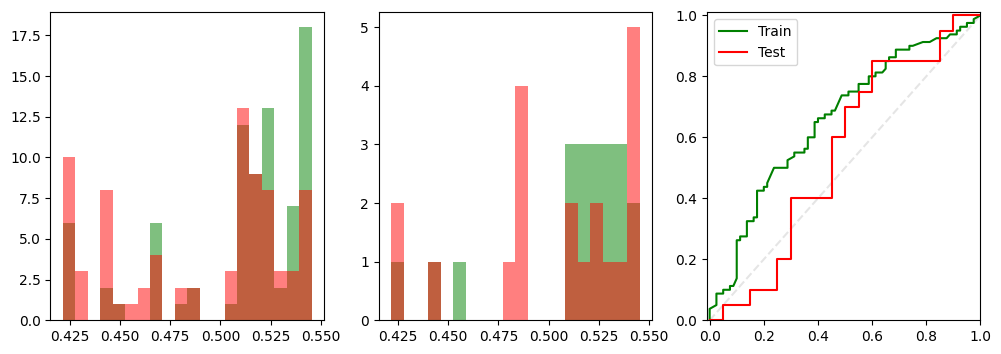

In [29]:
model = LogisticRegression()
model.fit(h_train, y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

Train AUC       0.976953125
Test AUC        0.575
Train Accuracy  0.925
Test Accuracy   0.625


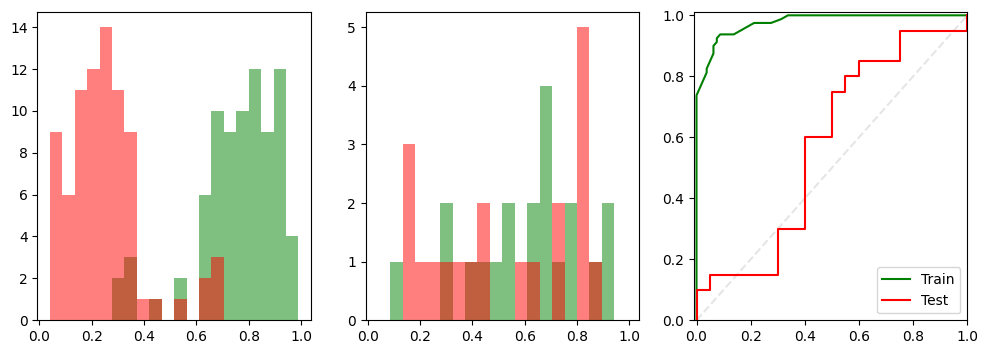

In [30]:
model = RandomForestClassifier()
model.fit(h_train, y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

Pretty bad lol

### 3. Learning-based attack from smallest scores

In [31]:
localize = lambda x: np.sort(x, axis=1)[:,-10:]

Train AUC       0.5225
Test AUC        0.5549999999999999
Train Accuracy  0.55625
Test Accuracy   0.625


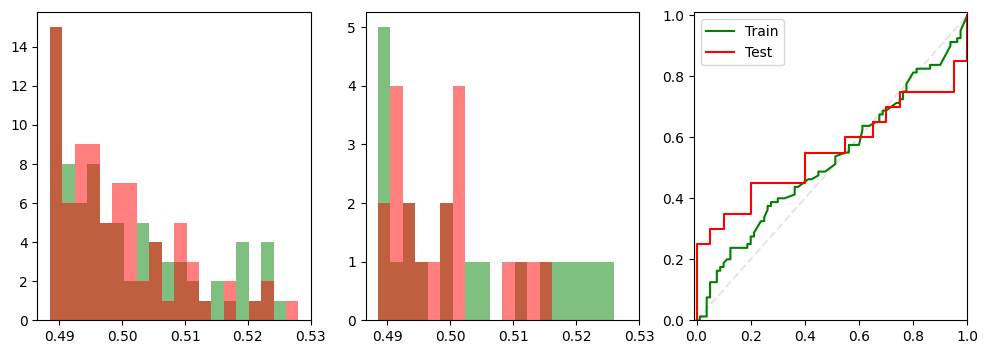

In [32]:
model = LogisticRegression()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

This is pretty much as good as taking decisions based on the smallest distance.

Train AUC       0.94125
Test AUC        0.5775
Train Accuracy  0.8625
Test Accuracy   0.6000000000000001


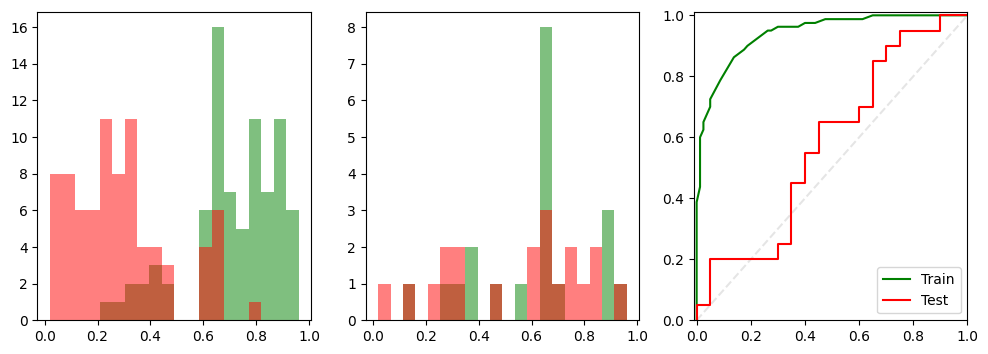

In [33]:
model = RandomForestClassifier()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

### 4. Learning-based attacks without any feature engineering

Train AUC       0.526875
Test AUC        0.555
Train Accuracy  0.575
Test Accuracy   0.625


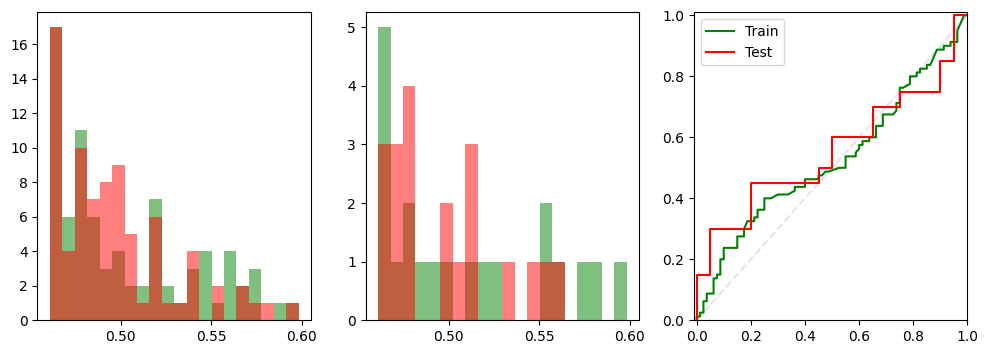

In [34]:
model = LogisticRegression()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

Train AUC       0.977109375
Test AUC        0.51
Train Accuracy  0.925
Test Accuracy   0.575


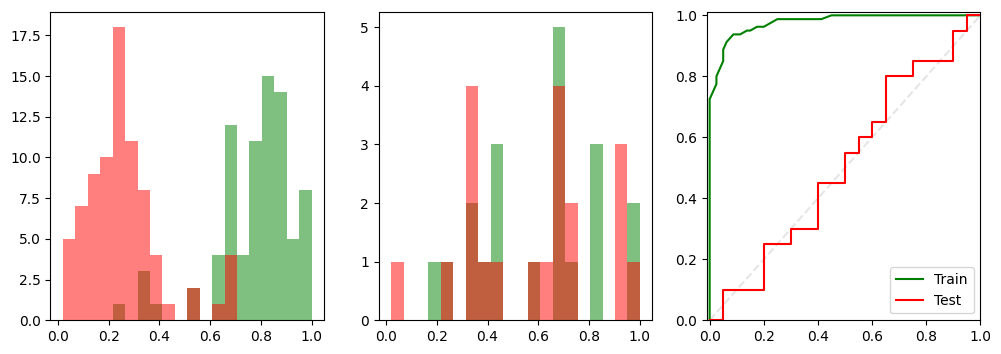

In [35]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

Train AUC       0.520234375
Test AUC        0.555
Train Accuracy  0.5687500000000001
Test Accuracy   0.625


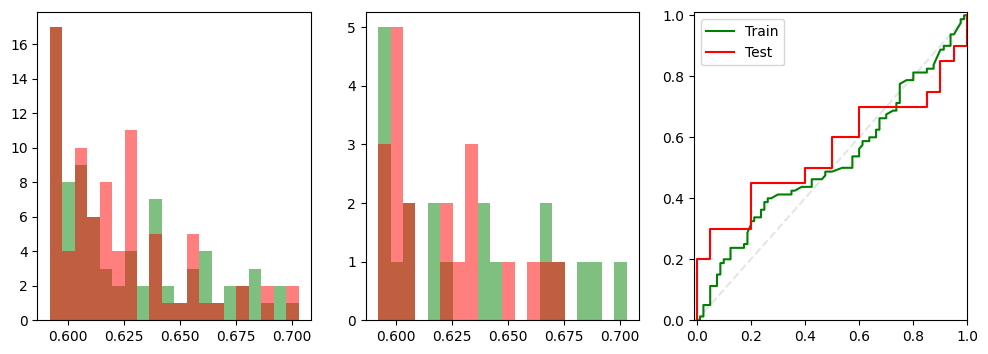

In [36]:
model = MLPClassifier(hidden_layer_sizes=[1000])
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

---

## Test dataset

We have run GraphRNN on a *second* (completely different) dataset from the same distribution. We will now evaluate the successful attacks on this dataset.

Warning: there will be heavy code re-use in this section. In fact, we will reuse *all* the code from above by swapping X_train and X_test to be the first and second release (rather than subsets of the first release).

First, we rework the `_train` variables to be for the original release.

In [37]:
num_train = len(training_graphs)
X_train = kernel.transform(_grak(training_graphs + holdout_graphs_train))
y_train = np.array([True]*num_train + [False]*num_train)

Second, we load the testing data and use that.

In [38]:
testing_graphs = list(TEST.data)
holdout_graphs_test = list(HOLDOUT_TEST.data)

In [39]:
synthetic_graphs_2 = load_graphs(
    '../../../graph_gen_testing/techniques/graph_rnn/graphs/deezer_subset_test_none_GraphRNN_RNN/GraphRNN_RNN_custom_multiple_deezer_subset_test_none_4_128__pred_200_1_edgelist.pkl'
)
print(len(synthetic_graphs_2))

1024


Fit the kernel to extract features.

In [40]:
kernel.fit(_grak(synthetic_graphs_2))

WeisfeilerLehman(n_iter=4, normalize=True)

In [41]:
num_test = len(testing_graphs)
X_test = kernel.transform(_grak(testing_graphs + holdout_graphs_test))
y_test = np.array([True]*num_train + [False]*num_train)

We have to redefine this function to reset internal variables.

In [42]:
def evaluate_score(scoref):
    score_train = scoref(X_train)
    score_test = scoref(X_test)
    lb = min(score_train.min(), score_test.min())
    ub = max(score_train.max(), score_train.max())
    bins = np.linspace(lb, ub, 21)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(score_train[y_train], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_train[~y_train], bins=bins, facecolor='b', alpha=.5)
    plt.subplot(1, 3, 2)
    plt.hist(score_test[y_test], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_test[~y_test], bins=bins, facecolor='b', alpha=.5)
    plt.subplot(1, 3, 3)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    fp_train, tp_train, _ = roc_curve(y_train, score_train)
    fp_test, tp_test, _ = roc_curve(y_test, score_test)
    plt.plot(fp_train, tp_train, 'g', label='Train')
    plt.plot(fp_test, tp_test, 'b', label='Test')
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend()

    ev = [('AUC', roc_auc_score), ('Accuracy', max_accuracy)]
    for label, f in ev:
        print(f'Train {label.ljust(8)} ', f(y_train, score_train))
        print(f'Test {label.ljust(8)}  ', f(y_test, score_test))

#### Attack 4:  random forest classifier without feature engineering.

Train AUC       0.97295
Test AUC        0.52405
Train Accuracy  0.915
Test Accuracy   0.5249999999999999


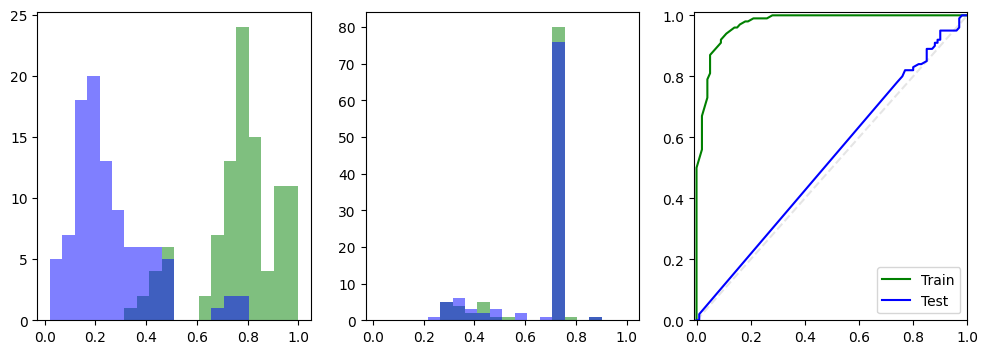

In [43]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

This attack does not transfer to another dataset, as expected.

In [44]:
np.max(X_test)

0.2

In [45]:
np.min(X_test)

0.053802758684897034

In [46]:
np.max(X_train)

0.21855599704010764

In [47]:
np.min(X_train)

0.07985494095046905

#### Attack 2: learning over histograms

In [48]:
hist = lambda x: histogram(x, lb=0.05, ub=0.22, k=100)

Train AUC       0.97045
Test AUC        0.5295
Train Accuracy  0.915
Test Accuracy   0.535


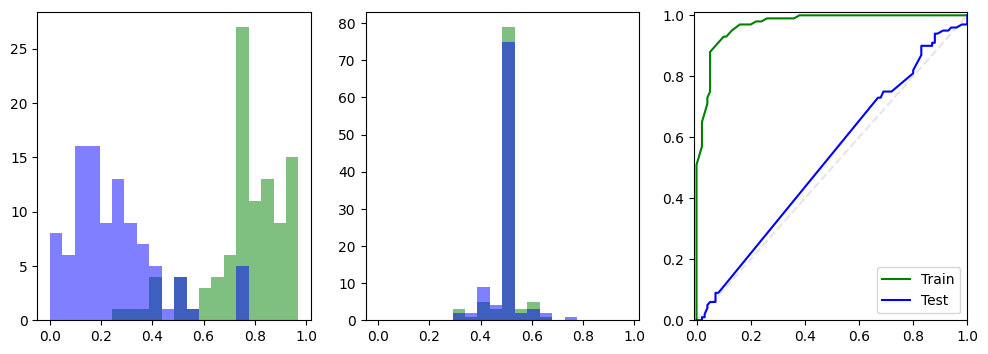

In [49]:
model = RandomForestClassifier()
model.fit(hist(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

Train AUC       0.7933
Test AUC        0.49855000000000005
Train Accuracy  0.72
Test Accuracy   0.535


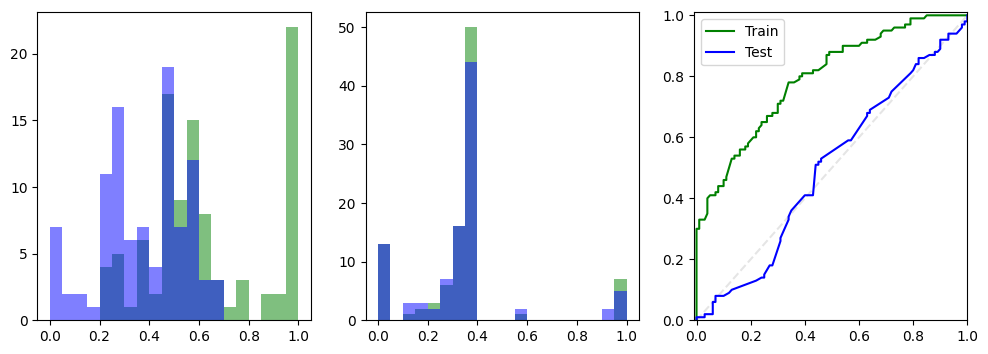

In [50]:
model = MLPClassifier(hidden_layer_sizes=[1000], max_iter=1000)
model.fit(hist(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

#### Learning-based over closest neighbours

Train AUC       0.5268999999999999
Test AUC        0.47655
Train Accuracy  0.5700000000000001
Test Accuracy   0.525


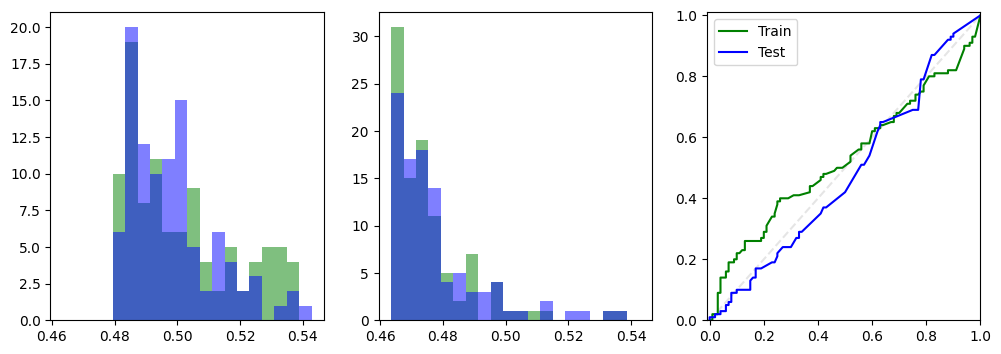

In [51]:
model = LogisticRegression()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

Train AUC       0.9331999999999999
Test AUC        0.5082000000000001
Train Accuracy  0.865
Test Accuracy   0.5249999999999999


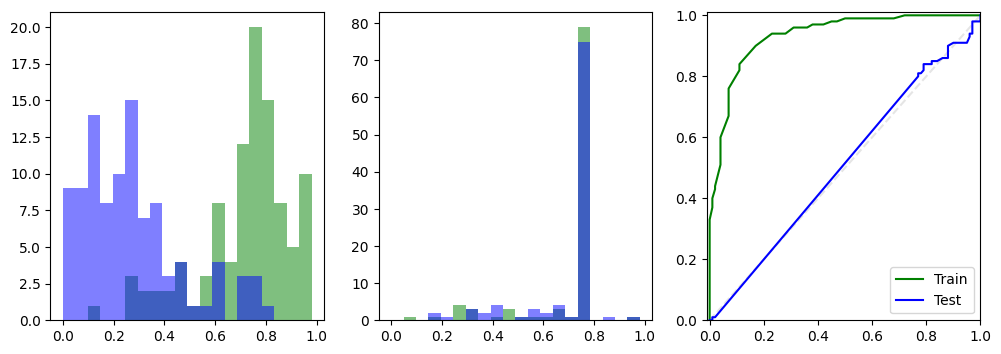

In [52]:
model = RandomForestClassifier()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

Train AUC       0.5268999999999999
Test AUC        0.4764
Train Accuracy  0.5700000000000001
Test Accuracy   0.525


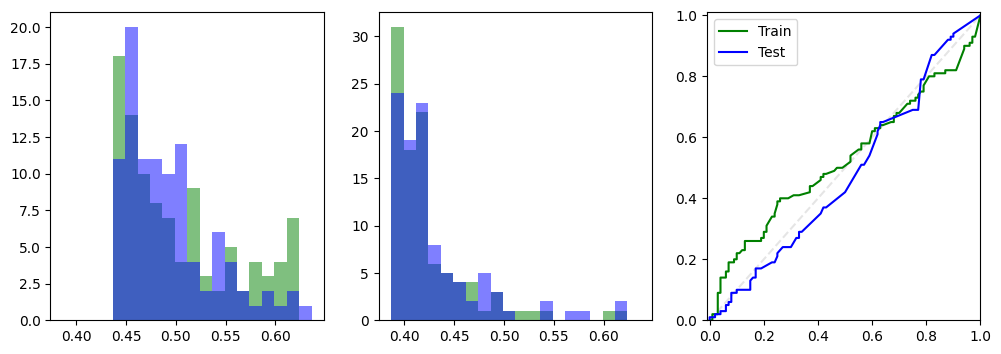

In [53]:
model = MLPClassifier(hidden_layer_sizes=[1000])
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

#### Attack 1: Score-based from the maximum

Here we do even simpler: no need for all this fancy learning stuff, just extract the score. It works well (better?).

Train AUC       0.5309
Test AUC        0.4769
Train Accuracy  0.5650000000000001
Test Accuracy   0.525


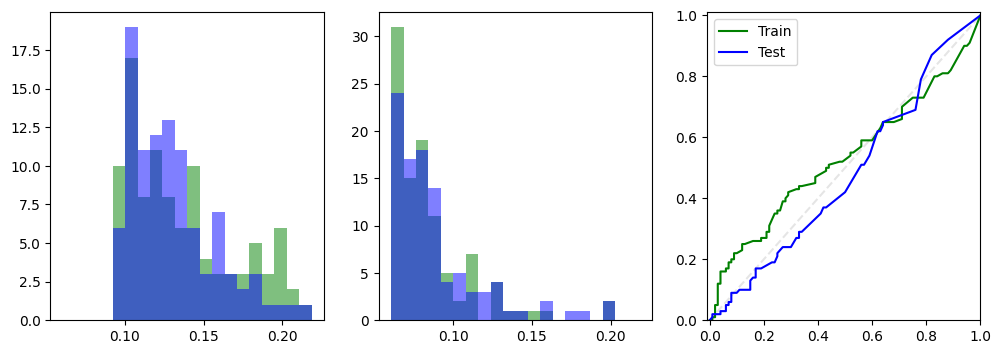

In [54]:
evaluate_score(lambda x: x.max(axis=1))